In [1]:
import pandas
import numpy

import seaborn
from matplotlib import pyplot as plt

In [18]:


def load_data_stream(path):

    # the data stream is comma-separated values
    # but with multiple different event types
    # with a variable amount of actual data
    columns = ['event', 'tick'] + list(range(0,10))
    df = pandas.read_csv(path, header=None, names=columns, engine='python')
    
    return df

def extract_sensor_data(events, marker='val'):
    df = events[events.event == marker]
    df = df.rename(columns={0: 'r', 1: 'g', 2: 'b'})
    df = df[['tick', 'r', 'g', 'b']]
    df = df.set_index('tick')
    
    return df

def extract_button_data(events, marker='button'):
    df = events[events.event == marker]
    df = df.rename(columns={0: 'state'})
    df = df[['tick', 'state']]
    df = df.set_index('tick')
    return df
    
def load_color_detector_data(path):
    events = load_data_stream(path)
    
    sensor_data = extract_sensor_data(events)
    button_data = extract_button_data(events).rename(columns={'state': 'button'})
    
    # tick values are actually shared, can be merged easily into one time-series
    combined = pandas.merge(sensor_data, button_data, right_index=True, left_index=True)
    
    return combined
    
path = './data/cards-2hz-100ms-2.csv'
data = load_color_detector_data(path)
data.head()

,r,g,b,button
tick,,,,
36000,84,37.0,193.0,0
36500,83,36.0,192.0,0
37000,84,36.0,193.0,0
37500,83,35.0,191.0,0
38000,84,36.0,192.0,0


<AxesSubplot: xlabel='tick', ylabel='button'>

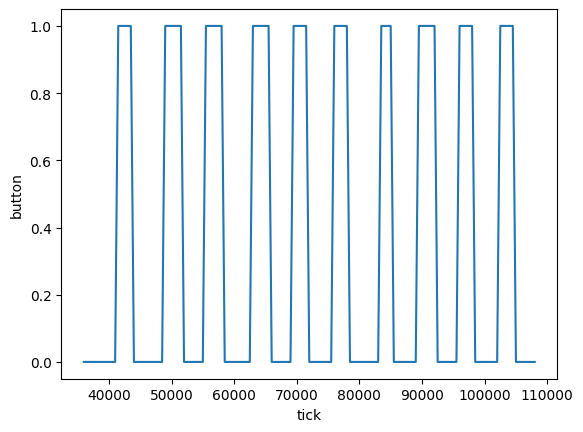

In [19]:
seaborn.lineplot(data=data.reset_index(), x='tick', y='button')

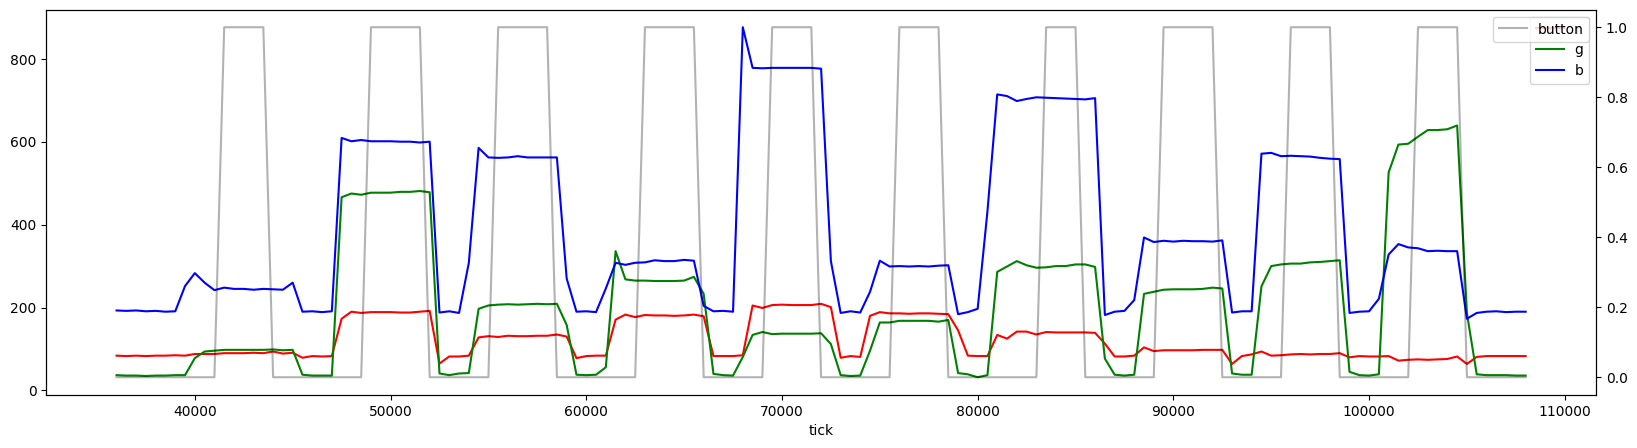

In [61]:

def plot_timeseries(data, time_column='tick'):
    dd = data.reset_index()
    
    # XXX: seaborn does not handle gaps with NaN values, but pandas.DataFrame.plot does
    fig, ax = plt.subplots(1, figsize=(20, 5))
    for col in ['r', 'g', 'b']:
        color = col
        dd.plot(ax=ax, x=time_column, y=col, color=color)

    ax2 = ax.twinx()
    dd.plot(ax=ax2, x=time_column, y='button', color='black', alpha=0.3) 
    
plot_timeseries(data)

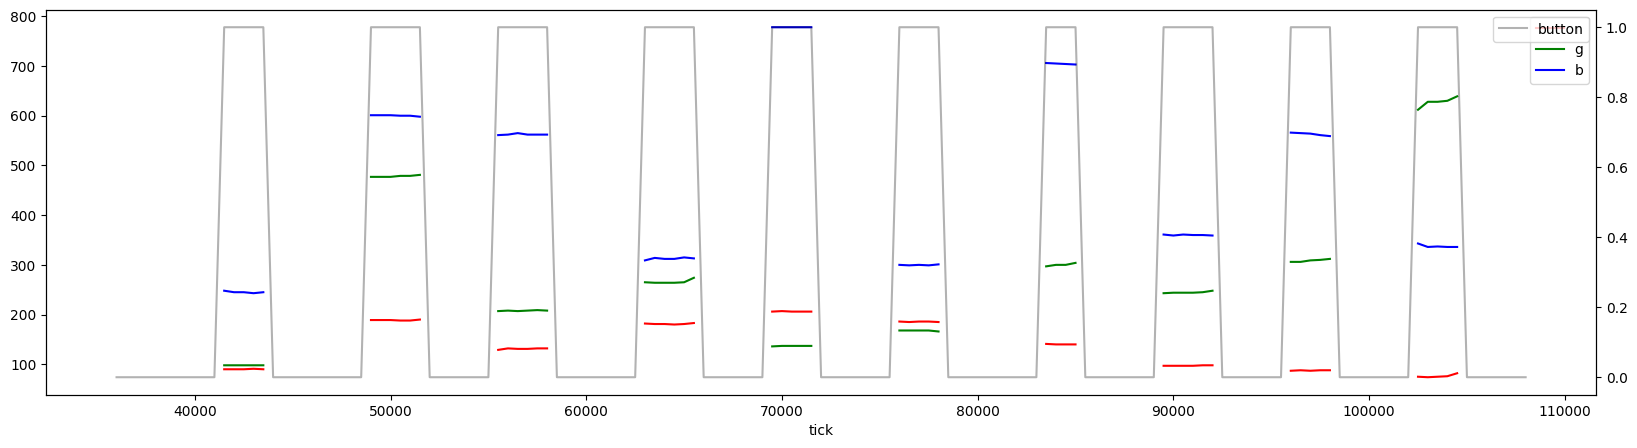

In [62]:

def mask_timeseries(df, mask_column, columns=None, value=numpy.nan):
    df = df.copy() # avoid mutating input
    
    if columns is None:
        columns = list(set(df.columns) - set([mask_column]))
    
    is_masked = df[mask_column].astype(bool) == False
    for col in columns:
        df.loc[is_masked, col] = value
    
    return df

plot_timeseries(mask_timeseries(data, 'button'))

In [82]:
card_data_order = [
    'black',
    'white',
    'cardboard_grey',
    'pink',
    'yellow',
    'red',
    'light_green',
    'purple',
    'blue',
    'dark_blue',
]
def make_label_mapping(section_labels):

    label_mapping = { numpy.nan: 'ambient' }
    for idx, label in enumerate(section_labels):
        label_mapping[idx] = label
    return label_mapping

label_mapping = make_label_mapping(card_data_order)
label_mapping

{nan: 'ambient',
 0: 'black',
 1: 'white',
 2: 'cardboard_grey',
 3: 'pink',
 4: 'yellow',
 5: 'red',
 6: 'light_green',
 7: 'purple',
 8: 'blue',
 9: 'dark_blue'}

In [101]:
def mark_sections(df, indicator, name='section'):
    assert len(df) == len(indicator)
    
    #dropped = df.dropna()
    
    section_number = -1
    section_labels = []
    in_section = indicator.iloc[0]
    for ind, (_, row) in zip(indicator, df.iterrows()):
        
        if not in_section and ind:
            # start section
            in_section = True
            section_number += 1
            
        if in_section and not ind:
            # end section
            in_section = False
        

        v = section_number if in_section else numpy.nan
        section_labels.append(v)
    
    s = pandas.Series(section_labels, index=df.index, name='section')
    #print(s.value_counts().sort_index())
    out = pandas.merge(df, s, right_index=True, left_index=True)
    return out

# TODO: ignore data just around the edge of button being pressed. Is probably not representative of "ambient"
labeled_data = mark_sections(data, data['button'])
#labeled_data.dropna(subset=['section'])
labeled_data['label'] = labeled_data['section'].replace(label_mapping)
labeled_data['label'].value_counts()

ambient           92
white              6
cardboard_grey     6
pink               6
purple             6
black              5
yellow             5
red                5
blue               5
dark_blue          5
light_green        4
Name: label, dtype: int64

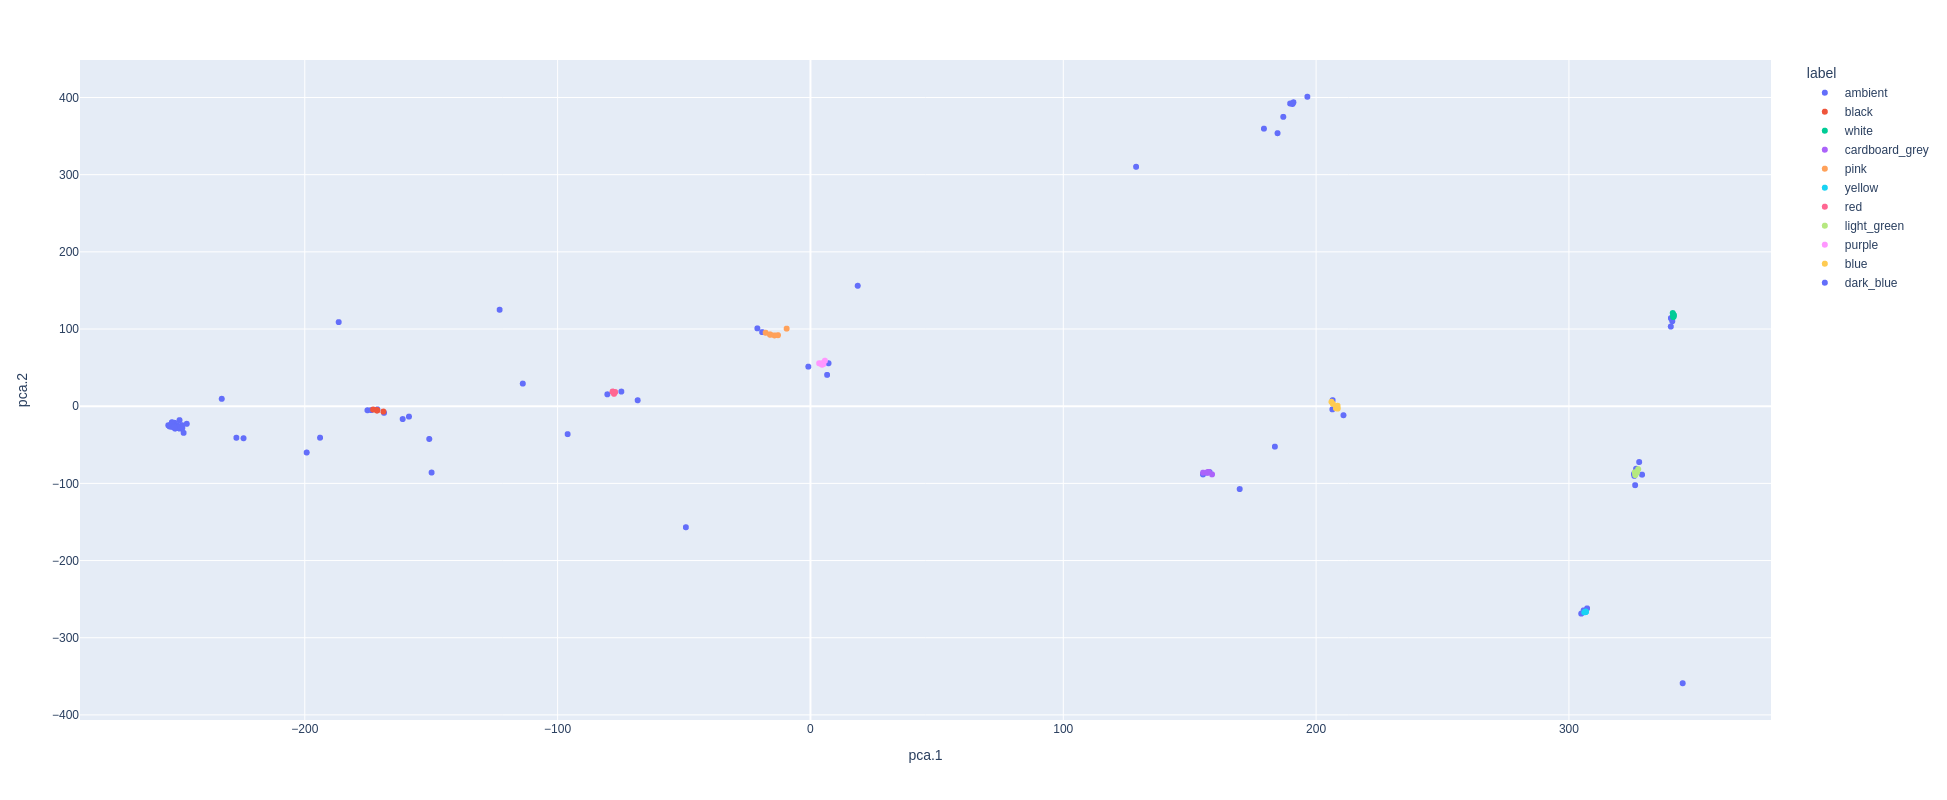

In [100]:

def plot_colors_2d(data, columns = ['r', 'g', 'b']):
    from sklearn.decomposition import PCA
    pca = PCA(2)

    dd = pca.fit_transform(data[columns])
    df = pandas.DataFrame(dd, columns=['pca.1', 'pca.2'], index=data.index)

    modded = pandas.merge(data, df, right_index=True, left_index=True)

    import plotly.express
    # FIXME: plot with (approximately) correct colors
    fig = plotly.express.scatter(modded, x='pca.1', y='pca.2',
                                 color='label',
                                 height=800, width=800)
    return fig

fig = plot_colors_2d(labeled_data)
fig